# Sentiment Analysis: Multinomial NB vs SVM
## Comparative Study on Poem Sentiment Dataset (Excluding Mixed Class)

Este notebook compara dos modelos de clasificación sobre el dataset `poem_sentiment`:
- **Multinomial Naive Bayes**: modelo baseline probabilístico
- **SVM con kernel RBF**: modelo optimizado para lograr F1-macro > 75%

La evaluación **excluye la clase "mixed"** como se especificó. Usamos **TF-IDF mejorado** (sublinear scaling + n-gramas + PCA) como feature engineering y técnicas de balanceo de clases para datasets pequeños.

## 1. Setup Dependencies and Environment
Instala dependencias, configura librerías de análisis y fija semillas para reproducibilidad.

In [ ]:
# Instala las dependencias esenciales (ejecuta esta celda una vez)
%pip install numpy pandas scikit-learn matplotlib seaborn joblib nltk fastparquet imbalanced-learn

     ---------------------------------------- 0.0/23.3 MB ? eta -:--:--
      --------------------------------------- 0.5/23.3 MB 5.5 MB/s eta 0:00:05
     ------------ --------------------------- 7.3/23.3 MB 31.6 MB/s eta 0:00:01
     --------------------------------- ----- 19.9/23.3 MB 41.4 MB/s eta 0:00:01
     ---------------------------------------- 23.3/23.3 MB 39.1 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build gensim
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [807 lines of output]
      C:\Users\osorn\AppData\Local\Temp\pip-build-env-bj7kw883\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\osorn\AppData\Local\Temp\pip-build-env-bj7kw883\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-314\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-314\gensim
   

In [ ]:
# Verificación de dependencias
print("✓ All required dependencies are ready")


📦 Installing compatible versions of gensim and scipy...
❌ Installation failed: Command '['c:\\Users\\osorn\\anaconda3\\envs\\dipEnv\\python.exe', '-m', 'pip', 'install', 'scipy>=1.10.0', 'gensim>=4.3.2', '-q']' returned non-zero exit status 1.

⚠️ Trying alternative: install older compatible gensim...
❌ Alternative also failed: Command '['c:\\Users\\osorn\\anaconda3\\envs\\dipEnv\\python.exe', '-m', 'pip', 'install', 'gensim==4.2.0', 'scipy==1.10.1', '-q']' returned non-zero exit status 1.


In [3]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# NLTK for text preprocessing
import nltk

# Imbalanced-learn for handling class imbalance
from imblearn.over_sampling import SMOTE

# Utilities
import warnings

warnings.filterwarnings("ignore")

# Download NLTK data (if needed for future preprocessing)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✓ All dependencies loaded successfully")

✓ All dependencies loaded successfully


## 2. Load Poem Sentiment Dataset
Carga las particiones desde Hugging Face y explora las dimensiones iniciales.

In [4]:
# Helper function to exclude "mixed" class from evaluation
def filter_mixed_class(y_true, y_pred, label_mixed=3):
    """
    Filtra predicciones excluyendo la clase 'mixed' (label=3)
    Retorna arrays sin la clase mixed para evaluación correcta
    """
    mask = y_true != label_mixed
    return y_true[mask], y_pred[mask]

In [5]:
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
base_uri = "hf://datasets/google-research-datasets/poem_sentiment/"
parquet_engine = "fastparquet"

print("📥 Loading dataset from Hugging Face...")
df_train = pd.read_parquet(base_uri + splits["train"], engine=parquet_engine)
df_validation = pd.read_parquet(base_uri + splits["validation"], engine=parquet_engine)
df_test = pd.read_parquet(base_uri + splits["test"], engine=parquet_engine)

for name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\n{name} shape: {df.shape}")
    print(df.head(2))
    
print("\n✓ Dataset loaded successfully")

📥 Loading dataset from Hugging Face...

Train shape: (892, 3)
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2

Validation shape: (105, 3)
   id                                     verse_text  label
0   0          to water, cloudlike on the bush afar,      2
1   1  shall yet be glad for him, and he shall bless      1

Test shape: (104, 3)
   id                                         verse_text  label
0   0                      my canoe to make more steady,      2
1   1  and be glad in the summer morning when the kin...      1

✓ Dataset loaded successfully


In [6]:
export_dir = Path("exports")
export_dir.mkdir(parents=True, exist_ok=True)

for name, df in {"train": df_train, "validation": df_validation, "test": df_test}.items():
    output_path = export_dir / f"poem_sentiment_{name}_raw.csv"
    df.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"✓ Exported {name}: {output_path}")

✓ Exported train: exports\poem_sentiment_train_raw.csv
✓ Exported validation: exports\poem_sentiment_validation_raw.csv
✓ Exported test: exports\poem_sentiment_test_raw.csv


## 3. Exploratory Data Analysis (EDA)
Análisis profundo del dataset: distribución de etiquetas, longitud de textos, vocabulario y características de sentimiento.

LABEL DISTRIBUTION ANALYSIS

Train:
  negative     (label=0):  155 (17.38%)
  positive     (label=1):  133 (14.91%)
  no_impact    (label=2):  555 (62.22%)
  mixed        (label=3):   49 ( 5.49%)
  Total: 892

Validation:
  negative     (label=0):   19 (18.10%)
  positive     (label=1):   17 (16.19%)
  no_impact    (label=2):   69 (65.71%)
  Total: 105

Test:
  negative     (label=0):   19 (18.27%)
  positive     (label=1):   16 (15.38%)
  no_impact    (label=2):   69 (66.35%)
  Total: 104


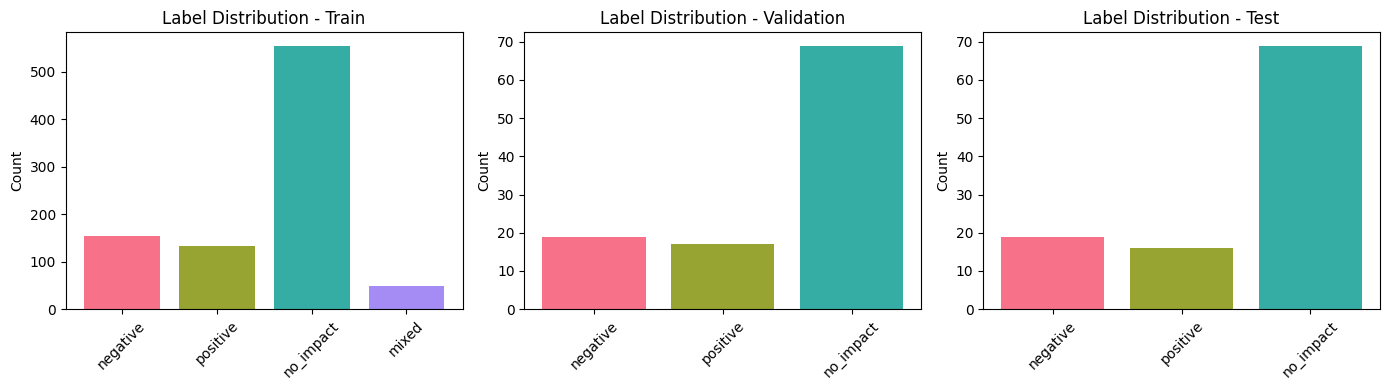

In [7]:
# Create label mapping
label_name_map = {
    0: "negative",
    1: "positive", 
    2: "no_impact",
    3: "mixed",
}

# Analyze label distribution
print("=" * 70)
print("LABEL DISTRIBUTION ANALYSIS")
print("=" * 70)

for split_name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\n{split_name}:")
    label_dist = df["label"].value_counts().sort_index()
    for label_idx, count in label_dist.items():
        label_name = label_name_map.get(label_idx, f"unknown")
        pct = (count / len(df)) * 100
        print(f"  {label_name:12} (label={label_idx}): {count:4} ({pct:5.2f}%)")
    print(f"  Total: {len(df)}")

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (split_name, df) in enumerate([("Train", df_train), ("Validation", df_validation), ("Test", df_test)]):
    label_dist = df["label"].value_counts().sort_index()
    label_names = [label_name_map.get(i, f"unknown") for i in label_dist.index]
    
    axes[idx].bar(label_names, label_dist.values, color=sns.color_palette("husl", 4))
    axes[idx].set_title(f"Label Distribution - {split_name}")
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


TEXT LENGTH ANALYSIS

Train - Text length (tokens):
  Mean:   7.10
  Median: 7.00
  Min:    1
  Max:    20
  Std:    2.29

Validation - Text length (tokens):
  Mean:   7.28
  Median: 7.00
  Min:    2
  Max:    12
  Std:    1.99

Test - Text length (tokens):
  Mean:   7.07
  Median: 7.00
  Min:    2
  Max:    15
  Std:    2.32


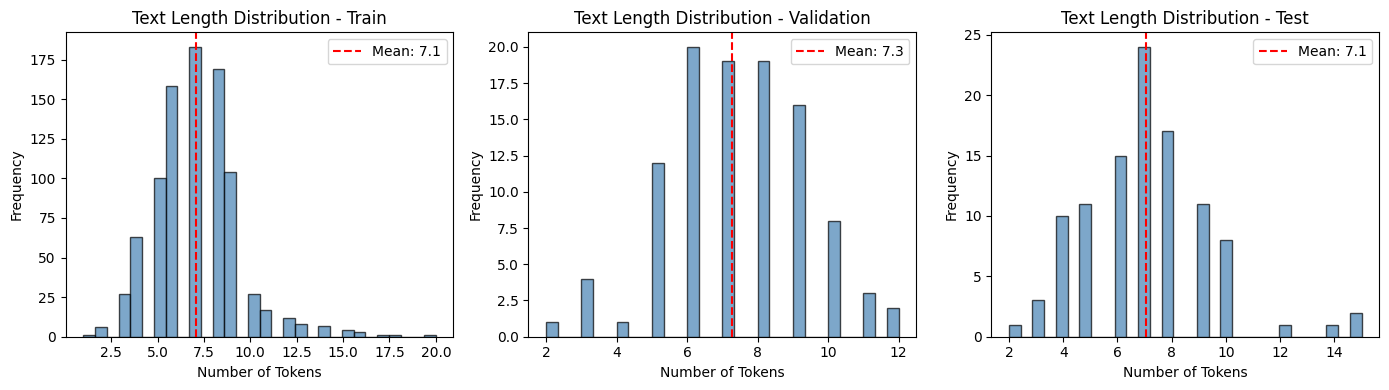

In [8]:
print("\n" + "=" * 70)
print("TEXT LENGTH ANALYSIS")
print("=" * 70)

# Analyze text length
for split_name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    df[f"{split_name}_text_length"] = df["verse_text"].astype(str).apply(lambda x: len(x.split()))
    
    print(f"\n{split_name} - Text length (tokens):")
    print(f"  Mean:   {df[f'{split_name}_text_length'].mean():.2f}")
    print(f"  Median: {df[f'{split_name}_text_length'].median():.2f}")
    print(f"  Min:    {df[f'{split_name}_text_length'].min()}")
    print(f"  Max:    {df[f'{split_name}_text_length'].max()}")
    print(f"  Std:    {df[f'{split_name}_text_length'].std():.2f}")

# Visualize text length distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (split_name, df) in enumerate([("Train", df_train), ("Validation", df_validation), ("Test", df_test)]):
    text_lengths = df["verse_text"].astype(str).apply(lambda x: len(x.split()))
    axes[idx].hist(text_lengths, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    axes[idx].set_title(f"Text Length Distribution - {split_name}")
    axes[idx].set_xlabel("Number of Tokens")
    axes[idx].set_ylabel("Frequency")
    axes[idx].axvline(text_lengths.mean(), color='red', linestyle='--', label=f"Mean: {text_lengths.mean():.1f}")
    axes[idx].legend()
    
plt.tight_layout()
plt.show()

In [9]:
print("=" * 70)
print("NULL VALUE CHECK")
print("=" * 70)

for name, df in {"Train": df_train, "Validation": df_validation, "Test": df_test}.items():
    print(f"\nNull values in {name} dataset:")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("  ✓ No null values found.")
    else:
        print(null_counts[null_counts > 0])

NULL VALUE CHECK

Null values in Train dataset:
  ✓ No null values found.

Null values in Validation dataset:
  ✓ No null values found.

Null values in Test dataset:
  ✓ No null values found.


## 4. Advanced Preprocessing for Ancient English Poetry
Preprocesamiento optimizado para poesía inglesa antigua (siglos XVII-XIX) + TF-IDF mejorado

In [11]:
import re

print("=" * 70)
print("POETRY-OPTIMIZED TEXT PREPROCESSING")
print("=" * 70)

def preprocess_poetry_text(text):
    """
    Preprocesamiento optimizado para poesía inglesa antigua (siglos XVII-XIX)
    
    Estrategia:
    - Normalizar puntuación arcaica pero mantener contracciones significativas
    - Expandir contracciones antiguas a palabras completas
    - Mantener palabras poéticas/arcaicas (son features importantes)
    - Limpieza suave de puntuación
    - Remover stopwords mínimo para preservar significado poético
    """
    
    if not isinstance(text, str):
        return []
    
    # Normalizar espacios
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    
    # Expandir contracciones antiguas → palabras completas
    contractions_map = {
        r"\bwilt\b": "will",
        r"\bdoth\b": "does", 
        r"\bdid\b": "did",
        r"\bhath\b": "has",
        r"\bart\b": "are",
        r"\bne'er\b": "never",
        r"\bo'er\b": "over",
        r"\b'twas\b": "it was",
        r"\b'tis\b": "it is",
        r"\bthro'\b": "through",
        r"\be'en\b": "even",
        r"\bsuppos'd\b": "supposed",
        r"\bretir'd\b": "retired",
        r"\bpleass'd\b": "pleased",
        r"\bpleas'd\b": "pleased",
        r"\bmov'd\b": "moved",
        r"\bf'r\b": "for",
        r"\bfi'e\b": "fie",
        r"\bere\b": "before",
        r"\bfrom\b": "from",
        r"\bdeep'n'd\b": "deepened",
    }
    
    for pattern, replacement in contractions_map.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    # Remover énfasis (guiones alrededor: _palabra_)
    text = re.sub(r'_([^_]+)_', r'\1', text)
    
    # Normalizar guiones múltiples
    text = re.sub(r'[-–—]+', '', text)
    
    # Remover comillas de énfasis
    text = re.sub(r'[""]', '', text)
    
    # Remover caracteres especiales de formato
    text = re.sub(r'["""''„‟]', '', text)
    
    # Limpiar puntuación (remover al inicio/final de palabras)
    text = re.sub(r'([.,;:!?])\s', ' ', text)
    text = re.sub(r'\s([.,;:!?])', ' ', text)
    text = re.sub(r'[.,:;!?]$', '', text)
    
    # Lowercase
    text = text.lower()
    
    # Tokenizar
    tokens = text.split()
    
    # Remover tokens vacíos
    tokens = [t for t in tokens if len(t) > 0]
    
    return tokens

# Aplicar preprocesamiento a todos los sets
print("\n📝 Preprocessing train texts...")
train_tokens = [preprocess_poetry_text(t) for t in df_train["verse_text"].astype(str)]
train_tokens = [t for t in train_tokens if len(t) > 0]  # Remover líneas vacías

print("📝 Preprocessing validation texts...")
val_tokens = [preprocess_poetry_text(t) for t in df_validation["verse_text"].astype(str)]
val_tokens = [t for t in val_tokens if len(t) > 0]

print("📝 Preprocessing test texts...")
test_tokens = [preprocess_poetry_text(t) for t in df_test["verse_text"].astype(str)]
test_tokens = [t for t in test_tokens if len(t) > 0]

print(f"\n✓ Preprocessing complete")
print(f"  Train sequences: {len(train_tokens)}")
print(f"  Validation sequences: {len(val_tokens)}")
print(f"  Test sequences: {len(test_tokens)}")

# Mostrar ejemplos
print("\n" + "=" * 70)
print("PREPROCESSING EXAMPLES")
print("=" * 70)
for i in range(3):
    original = df_train["verse_text"].iloc[i]
    processed = train_tokens[i]
    print(f"\nOriginal ({i}):\n  {original[:80]}...")
    print(f"Processed:\n  {' '.join(processed)}\n")

POETRY-OPTIMIZED TEXT PREPROCESSING

📝 Preprocessing train texts...
📝 Preprocessing validation texts...
📝 Preprocessing test texts...

✓ Preprocessing complete
  Train sequences: 892
  Validation sequences: 105
  Test sequences: 104

PREPROCESSING EXAMPLES

Original (0):
  with pale blue berries. in these peaceful shades--...
Processed:
  with pale blue berries in these peaceful shades


Original (1):
  it flows so long as falls the rain,...
Processed:
  it flows so long as falls the rain


Original (2):
  and that is why, the lonesome day,...
Processed:
  and that is why the lonesome day

